In [26]:
# -*- coding: utf-8 -*-

'''
This script builds on Third_PneumoniaModel_Train&Test.ipynb and implements transfer learning using the ResNet34 architecture to create a pneumonia detection model with PyTorch. 
The pre-trained ResNet34 is fine-tuned to classify chest X-rays as either healthy or pneumonia-affected.

To enhance generalisation and address overfitting, the model incorporates dropout layers, data augmentation, early stopping, and learning rate scheduling. 
The training process utilises the Adam optimiser and balanced sampling to manage class imbalances effectively. 
Performance evaluation includes metrics such as precision, recall, F1-score, and a confusion matrix.

References:
- VassiliPH, (2023). Chest X-Ray Images - PyTorch Step by Step (Acc ~94%). Kaggle. Available at: https://www.kaggle.com/code/vassiliph/chest-xray-images-pytorch-step-by-step-acc-94 [Accessed 7 Dec. 2024].
- NCCA, (n.d.). jmacey. (2024). PreTrainedModelsPart1.ipynb. Available at: https://github.com/NCCA/SEForMedia/blob/main/PreTrainedModels/PreTrainedModelsPart1.ipynb [Accessed: 20 December 2024].
- NCCA, (n.d.). jmacey. (2024). TransferLearning.ipynb. Available at: https://github.com/NCCA/SEForMedia/blob/main/PreTrainedModels/TransferLearning.ipynb [Accessed: 20 December 2024].
'''

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, models
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

sys.path.append("../")
import Utils.TorchUtils as Utils

device = Utils.get_device()
print(f"Found Device: {device}")

Found Device: mps


In [27]:
# Constants for configuration
PRETRAINED_MODEL_PATH = 'pneumonia_detection_model.pth'
DATASET_LOCATION = 'chest_xray/chest_xray'
MODEL_SAVE_PATH = 'combined_pneumonia_models.pth' 
BATCH_SIZE = 32
EPOCHS = 20
PATIENCE_LIMIT = 5

In [28]:
# Data transformations for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [29]:
# The balanced sampler function should deal with the class imbalance
def balanced_sampler(dataset, index):
    class_counts = torch.bincount(torch.tensor([dataset.samples[i][1] for i in index], dtype=torch.int64))
    class_weights = 1.0 / class_counts.float()
    sample_weights = [class_weights[dataset.samples[i][1]] for i in index]
    return WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

def load_balanced_data(dataset_location, batch_size):
    full_dataset = datasets.ImageFolder(os.path.join(dataset_location, 'train'), transform=train_transform)

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_indeces, val_indeces = torch.utils.data.random_split(range(len(full_dataset)), [train_size, val_size])

    # Assign balanced sampler to train dataset 
    sampler = balanced_sampler(full_dataset, train_indeces)
    train_subset = torch.utils.data.Subset(full_dataset, train_indeces)
    val_subset = torch.utils.data.Subset(full_dataset, val_indeces)

    train_loader = DataLoader(train_subset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

train_loader, val_loader = load_balanced_data(DATASET_LOCATION, BATCH_SIZE)

In [30]:
# Building the combined model, pretrained model & ResNet34 with additionl layers
def build_model(weights='IMAGENET1K_V1'):
    model = models.resnet34(weights=weights)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)
    return model

resnet34 = build_model()

state_dict = torch.load(PRETRAINED_MODEL_PATH, map_location=device, weights_only=True)

class CombinedModel(nn.Module):
    def __init__(self, pretrained_model, state_dict):
        super(CombinedModel, self).__init__()
        self.pretrained_model = pretrained_model
        
        self.pretrained_model.load_state_dict(state_dict, strict=False)
        
        self.additional_layers = nn.Sequential(
            nn.Conv2d(512, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),
            nn.AdaptiveAvgPool2d((28, 28)),
            nn.Flatten(),
            nn.Linear(8 * 28 * 28, 512), 
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.pretrained_model(x)
        x = self.additional_layers(x)
        return x

model = CombinedModel(pretrained_model=resnet34, state_dict=state_dict).to(device)
print(f"Combined model created and moved to {device}")


Combined model created and moved to mps


In [31]:
def training_components(model, device):
    # Class weights to handle class imbalance
    class_weights = torch.tensor([1.0, 3.7]).to(device)
    loss_function = nn.CrossEntropyLoss(weight=class_weights)
    # Weight decay of 1e-6 to prevent overfitting
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    # The learning rate scheduler helps reduce the learning rate by 90% every 2 epochs
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    
    return loss_function, optimizer, scheduler

loss_function, optimizer, scheduler = training_components(model, device)

In [32]:
def validate_model(model, val_loader, loss_function, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy

def train_model(model, train_loader, val_loader, loss_function, optimizer, device, epochs, patience_limit):
    best_val_loss = float('inf')
    patience_counter = 0
    training_precision = []
    validation_precision = []

    for epoch in range(epochs):
        model.train()
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train
        training_precision.append(train_accuracy)

        val_loss, val_accuracy = validate_model(model, val_loader, loss_function, device)
        validation_precision.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} | Training Accuracy: {train_accuracy:.2f}% | Validation Accuracy: {val_accuracy:.2f}%")

        scheduler.step()
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
        else:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print("Early stopping triggered.")
                break

    return training_precision, validation_precision

In [33]:
def plot_training_validation_curves(training_precision, validation_precision):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(training_precision, 'b-')
    ax1.set_title('Training Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)')
    ax1.grid(True)
   
    ax2.plot(validation_precision, 'r-')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Final Training Accuracy: {training_precision[-1]:.2f}%")
    print(f"Final Validation Accuracy: {validation_precision[-1]:.2f}%")

Start training
Epoch 1/20 | Training Accuracy: 90.80% | Validation Accuracy: 94.35%
Epoch 2/20 | Training Accuracy: 94.01% | Validation Accuracy: 96.07%
Epoch 3/20 | Training Accuracy: 95.28% | Validation Accuracy: 97.03%
Epoch 4/20 | Training Accuracy: 96.36% | Validation Accuracy: 97.61%
Epoch 5/20 | Training Accuracy: 96.62% | Validation Accuracy: 97.41%
Epoch 6/20 | Training Accuracy: 96.64% | Validation Accuracy: 96.93%
Epoch 7/20 | Training Accuracy: 96.62% | Validation Accuracy: 96.74%
Epoch 8/20 | Training Accuracy: 97.12% | Validation Accuracy: 97.70%
Epoch 9/20 | Training Accuracy: 97.15% | Validation Accuracy: 96.84%
Epoch 10/20 | Training Accuracy: 97.05% | Validation Accuracy: 97.22%
Epoch 11/20 | Training Accuracy: 96.45% | Validation Accuracy: 97.80%
Early stopping triggered.


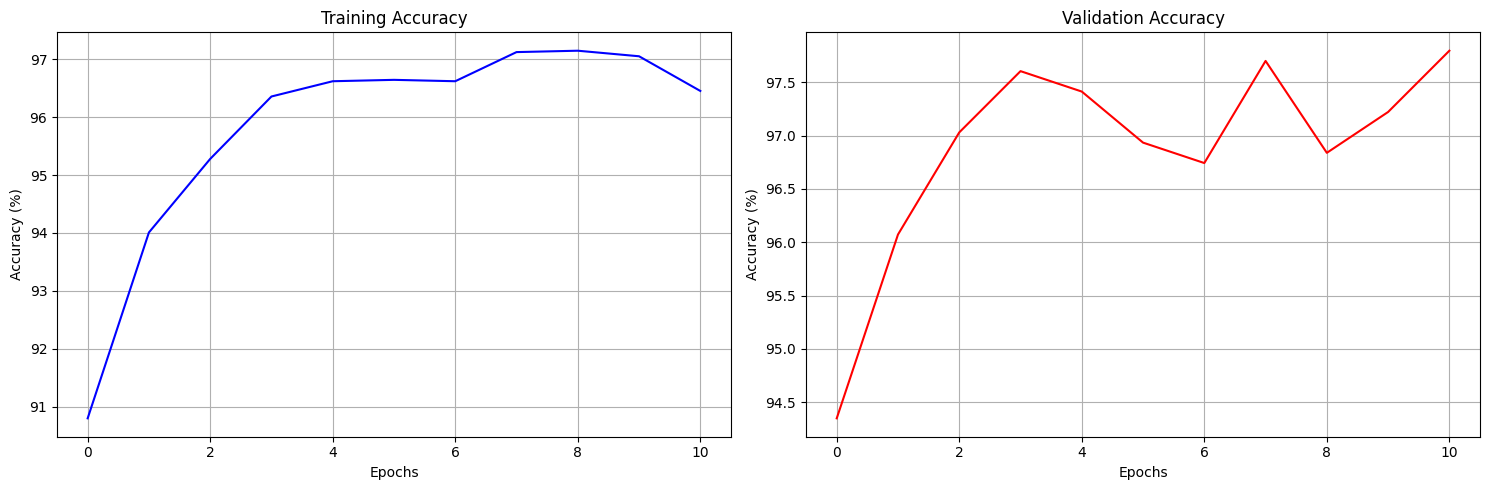

Final Training Accuracy: 96.45%
Final Validation Accuracy: 97.80%


In [34]:
model = build_model().to(device)
loss_function, optimizer, scheduler = training_components(model, device)

print("Start training")
training_precision, validation_precision = train_model(model, train_loader, val_loader, loss_function, optimizer, device, EPOCHS, PATIENCE_LIMIT)
plot_training_validation_curves(training_precision, validation_precision)

In [35]:
# Saving the two combined, previously trained models 
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved as {MODEL_SAVE_PATH}")

Model saved as combined_pneumonia_models.pth


In [36]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return all_labels, all_predictions

In [37]:
def plot_confusion_matrix(cm, class_names):
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)), class_names)

    # Adding the sample counts to the matrix
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha= 'center', va= 'center', color= 'white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


In [38]:
def calculate_metrics(all_labels, all_predictions, class_names):
    cm = confusion_matrix(all_labels, all_predictions)
    print(f"Precision: {precision_score(all_labels, all_predictions, average='binary'):.2f}")
    print(f"Recall: {recall_score(all_labels, all_predictions, average='binary'):.2f}")
    print(f"F1-Score: {f1_score(all_labels, all_predictions, average='binary'):.2f}")

    plot_confusion_matrix(cm, class_names)

In [39]:
def show_predictions_with_samples(model, test_loader, device, class_names, num_images=16):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)

    plt.figure(figsize=(12, 12))
    for i in range(min(num_images, len(images))):
        plt.subplot(4, 4, i + 1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)
        true_label = class_names[labels[i].item()]
        pred_label = class_names[predictions[i].item()]
        color = "green" if predictions[i] == labels[i] else "red"
        plt.imshow(img)
        plt.title(f"True: {true_label} | Predicted: {pred_label}", color=color, fontsize=8)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

Testing the model
Test Accuracy: 87.02%
Precision: 0.83
Recall: 0.99
F1-Score: 0.91


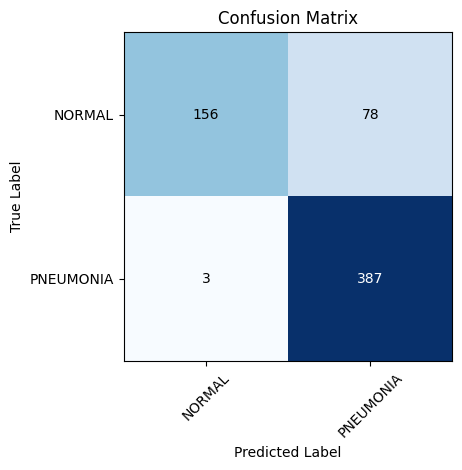

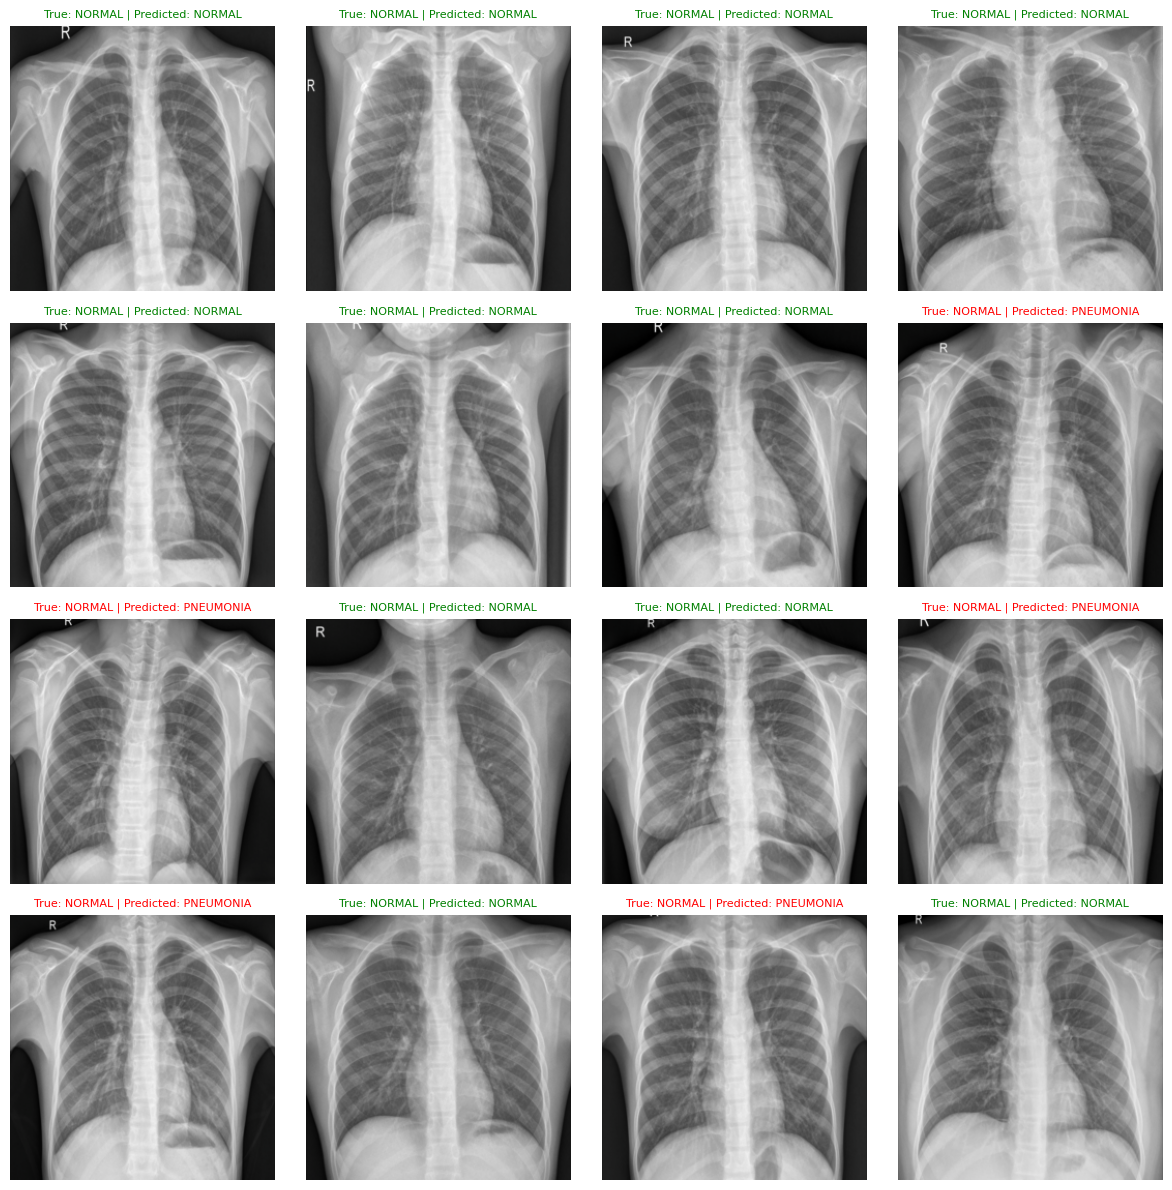

In [40]:
print("Testing the model")
test_dataset = datasets.ImageFolder(os.path.join(DATASET_LOCATION, 'test'), transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Loading and testing the model + metrics calculations & predicition visualisation
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device, weights_only=True))
model.to(device)
all_labels, all_predictions = test_model(model, test_loader, device)

class_names = test_dataset.classes
calculate_metrics(all_labels, all_predictions, class_names)

show_predictions_with_samples(model, test_loader, device, class_names, num_images=16)